In [85]:
from Bio.PDB import PDBParser
import time
import scipy
import time
import scipy.spatial
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [86]:
import asyncio
import os
import re
from playwright.async_api import async_playwright

def download_conservation_scores(pdb_file_path, chains, protein_id):
    pattern = r'pdb(\w+)\.pdb'
    pdb_ids = [match.group(1).upper() for file_path in pdb_file_path if (match := re.search(pattern, file_path))]
    print(pdb_ids)
    
    # Ensure the directory for saving files exists
    output_dir =f"{protein_id}_conservation_scores"
    os.makedirs(output_dir, exist_ok=True)

    async def scrape_consurf(pdb_id, chain):
        url = f"https://consurfdb.tau.ac.il/DB/{pdb_id.upper()}{chain}/{pdb_id.upper()}{chain}_consurf_summary.txt"
        async with async_playwright() as p:
            browser = await p.chromium.launch()
            page = await browser.new_page()
            try:
                await page.goto(url, timeout=60000)  # Increase timeout to 60 seconds
                content = await page.content()  # Get the content of the page
                if "Page not found" in content:
                    print(f"Error: Page not found for {pdb_id} chain {chain}")
                    return None
                else:
                    content = await page.text_content("body")  # Get the text content directly from the body
                    if content and "Page not found" not in content:
                        file_path = f"{output_dir}/{pdb_id}_consurf_summary.txt"
                        with open(file_path, "w") as file:
                            file.write(content)
                        print(f"Summary for {pdb_id} chain {chain} saved successfully at {file_path}.")
                        return content
                    else:
                        print(f"Content for {pdb_id} chain {chain} not found or invalid.")
                        return None
            except Exception as e:
                print(f"Error processing {pdb_id} chain {chain}: {e}")
                return None
            finally:
                await browser.close()

    async def main():
        tasks = []
        for pdb_id in pdb_ids:
            for chain in chains:
                tasks.append(scrape_consurf(pdb_id, chain))
        
        # Run all tasks concurrently and gather their results
        results = await asyncio.gather(*tasks, return_exceptions=True)
        
        for pdb_id, result in zip(pdb_ids, results):
            if isinstance(result, Exception):
                print(f"Error processing {pdb_id}: {result}")
            elif result:
                print(f"Summary for {pdb_id} saved successfully.")
            else:
                print(f"No content saved for {pdb_id}.")

    # Helper function to run the asyncio code in the correct context
    def run_async_code():
        try:
            loop = asyncio.get_running_loop()
            if loop.is_running():
                return loop.create_task(main())
        except RuntimeError:
            return asyncio.run(main())

    run_async_code()

In [87]:
def extract_conservation_score(filename):
    result = []
    try:
        with open(filename, 'r') as file:
            for line in file:
                # Skip header lines and lines below confidence cut-off
                if re.match(r'\s*\d+', line):
                    columns = line.split()
                    pos = int(columns[0])
                    score = float(columns[3])

                    # Check if there is a 3LATOM value, otherwise continue
                    if len(columns) > 6 and ':' in columns[2]:
                        residue_id = re.findall(r'\d+', columns[2])[0]  # Extract numbers from the string
                        residue_id = int(residue_id)  # Convert extracted string to integer
                        residue_name = re.findall(r'[A-Za-z]+', columns[2])[0]  # Extract letters from the string
                        result.append({'residue_id': residue_id, 'residue_name': residue_name, 'conservation_score': score})

        return result
    except Exception as e:
        print(f"Error processing file {filename}: {e}")
        return None


In [88]:
def extract_pdb_info(pdb_file_path):
    """
    Reads a PDB file and extracts 3D spatial coordinates and amino acids.

    Input: pdb_file_path (str): Path to the PDB file.

    Output:  A list of dictionaries, each containing information about each atom.
    """
    # Create a PDBParser object
    parser = PDBParser(PERMISSIVE=1)
    
    # Parse the structure from the PDB file
    structure = parser.get_structure('protein', pdb_file_path)
    
    # List to hold the extracted information
    atom_info_list = []

    # Extract information from the structure
    for model in structure:
        for chain in model:
            for residue in chain:
                for atom in residue:
                    atom_info = {
                        'model_id': model.id,
                        'chain_id': chain.id,
                        'residue_name': residue.resname,
                        'residue_id': residue.id[1],
                        'atom_name': atom.name,
                        'atom_coords': atom.coord.tolist()
                    }
                    atom_info_list.append(atom_info)

    return atom_info_list

In [89]:
def find_nearest_neighbors(data, angstrom):
    """
    Find the n-neighbors closest to the 'CA' atoms in the data using brute force with Euclidean distance.

    Parameters:
    - data: list of dictionaries, each containing atom information
    - angstrom: float, distance threshold for neighbor counting

    Returns:
    - data: list of dictionaries, containing only 'CA' atoms with updated 'neighbour_count' field,
      and without 'model_id', 'atom_name', and 'atom_coords' keys.
    """

    # Filter data to only include 'CA' atoms in chain_id 'A'
    ca_atoms_neighbour = [atom for atom in data if atom.get('chain_id') == 'A' and atom.get('atom_name') == 'CA']
    ca_coords = np.array([atom['atom_coords'] for atom in ca_atoms_neighbour])

    # Calculate distances between 'CA' atoms
    distances = scipy.spatial.distance.cdist(ca_coords, ca_coords, 'euclidean')

    # Use 'residue_id' for DataFrame indexing
    residue_ids = [atom.get('residue_id', f"residue_{i}") for i, atom in enumerate(ca_atoms_neighbour)]
    
    # Convert distance matrix to pandas DataFrame
    distance_df = pd.DataFrame(distances, index=residue_ids, columns=residue_ids)

    # Format distance matrix to 3 decimal places
    distance_df = distance_df.round(3)

    # Print the distance matrix
    #print("Distance matrix between CA atoms (formatted to 3 decimal places):")
    #print(distance_df)

    # Count neighbors within a distance of 'angstrom' units for each 'CA' atom
    for index, ca_point in enumerate(ca_coords):
        neighbour_count = np.sum((distances[index] <= angstrom) & (distances[index] != 0))
        ca_atoms_neighbour[index]['neighbour_count'] = neighbour_count

    # Remove specified keys from the 'CA' atoms
    keys_to_remove = ['model_id', 'atom_name', 'atom_coords']
    for atom in ca_atoms_neighbour:
        for key in keys_to_remove:
            atom.pop(key, None)

    return ca_atoms_neighbour


In [106]:
def find_hydrophobicity(data):
    hydrophobicity_scale = {"ALA": 1.8, "ARG": -4.5, "ASN": -3.5, "ASP": -3.5, "CYS": 2.5, "GLN": -3.5, "GLU": -3.5,
            "GLY": -0.4, "HIS": -3.2, "ILE": 4.5, "LEU": 3.8, "LYS": -3.9, "MET": 1.9, "PHE": 2.8,
            "PRO": -1.6, "SER": -0.8, "THR": -0.7, "TRP": -0.9, "TYR": -1.3, "VAL": 4.2}
        
    # Filter data to only include 'CA' atoms in chain_id 'A'
    ca_atoms_hydrophobicity = [atom for atom in data if atom.get('neighbour_count')]

    # Remove specified keys from the 'CA' atoms
    keys_to_remove = ['model_id', 'atom_name', 'atom_coords']
    for atom in ca_atoms_hydrophobicity:
        if atom["residue_name"] in hydrophobicity_scale:
            atom['hydrophobicity'] = hydrophobicity_scale[atom["residue_name"]]
        else:
            atom['hydrophobicity'] = None
        for key in keys_to_remove:
            atom.pop(key, None)
    
    return ca_atoms_hydrophobicity

In [107]:
def find_volume(data):
    volume_scale = {"ALA": 88.6, "ARG": 173.4, "ASN": 114.1, "ASP": 111.1, "CYS": 108.5, "GLN": 143.8, "GLU": 138.4,
            "GLY": 60.4, "HIS": 153.2, "ILE": 166.7, "LEU": 166.7, "LYS": 168.6, "MET": 162.9, "PHE": 189.9,
            "PRO": 112.7, "SER": 89.0, "THR": 116.1, "TRP": 227.8, "TYR": 193.6, "VAL": 140.0}
        
    # Filter data to only include 'CA' atoms in chain_id 'A'
    ca_atoms_volume = [atom for atom in data if atom.get('neighbour_count')]

    # Remove specified keys from the 'CA' atoms
    keys_to_remove = ['model_id', 'atom_name', 'atom_coords']
    
    for atom in ca_atoms_volume:
        if atom["residue_name"] in volume_scale:
            atom['volume'] = volume_scale[atom["residue_name"]]
        else:
            atom['volume'] = None
        for key in keys_to_remove:
            atom.pop(key, None)
    
    return ca_atoms_volume

In [92]:
def merge_residue_data(conservation_scores, neighbour_counts, hydrophobicities, volumes):
    # Create a dictionary to index the neighbour_counts by residue_id and residue_name
    neighbour_dict = {(item['residue_id'], item['residue_name']): item for item in neighbour_counts}
    hydrophobicity_dict = {(item['residue_id'], item['residue_name']): item for item in hydrophobicities}
    conservation_dict = {(item['residue_id'], item['residue_name']): item for item in conservation_scores}
    volume_dict = {(item['residue_id'], item['residue_name']): item for item in volumes}

    # Determine all unique residue identifiers
    all_residues = set(neighbour_dict.keys()).union(hydrophobicity_dict.keys(), conservation_dict.keys(), volume_dict.keys())

    # List to hold merged data
    merged_data = []
    
    # Merge data from conservation_scores with neighbour_counts
    for residue_id, residue_name in all_residues:
        merged_entry = {
            'residue_id': residue_id,
            'residue_name': residue_name,
            'conservation_score': conservation_dict.get((residue_id, residue_name), {}).get('conservation_score'),
            'neighbour_count': neighbour_dict.get((residue_id, residue_name), {}).get('neighbour_count'),
            'hydrophobicity': hydrophobicity_dict.get((residue_id, residue_name), {}).get('hydrophobicity'),
            'volume': volume_dict.get((residue_id, residue_name), {}).get('volume')
        }
        merged_data.append(merged_entry)
    
    # Sort the merged data by residue_id
    merged_data.sort(key=lambda x: x['residue_id'])


    return merged_data


In [93]:
def pdb_to_compiled_vector(pdb_file_path, angstrom, protein_id, num_residues):
    
    title = pdb_file_path.split('/')[-1].split('.')[0][3:].upper()

    atom_info_list = extract_pdb_info(pdb_file_path)
    
    neighbour_count = find_nearest_neighbors(atom_info_list, angstrom)

    hydrophobicity = find_hydrophobicity(atom_info_list)

    volume = find_volume(atom_info_list)
    
    print(f"Number of Amino Acids ({title}): {len(hydrophobicity)}")
    
    conservation_scores = extract_conservation_score(filename=f"{protein_id}_conservation_scores/{title}_consurf_summary.txt")

    if conservation_scores is not None:
        merged_residues = merge_residue_data(conservation_scores, neighbour_count, hydrophobicity, volume)
        print(f"Merged Residue ({title}):{merged_residues}")
    else:
        print(f"Conservation scores not found for {title}, skipping merge_residue_data. Going straight to plotting.")
        merged_residues = merge_residue_data([], neighbour_count, hydrophobicity, volume)

    return merged_residues

In [95]:
def merge_to_ref_seq(ref_seq, completed):
    # Convert ref_seq to dictionary for efficient lookup
    ref_seq_dict = {entry['residue_id']: entry for entry in ref_seq}
    print(f"Test {completed}")
    for entry in completed:
        residue_id = entry['residue_id']
        if residue_id in ref_seq_dict:
            ref_seq_entry = ref_seq_dict[residue_id]
            if 'neighbour_count' in entry:
                ref_seq_entry['neighbour_count'] = entry['neighbour_count']
            if 'conservation_score' in entry and entry['conservation_score'] is not None:
                ref_seq_entry['conservation_score'] = entry['conservation_score']
            if 'hydrophobicity' in entry:
                ref_seq_entry['hydrophobicity'] = entry['hydrophobicity']
            if 'volume' in entry:
                ref_seq_entry['volume'] = entry['volume']        
        else:
            ref_seq_dict[residue_id] = {
                'residue_id': residue_id,
                'residue_name': entry['residue_name'],
                'neighbour_count': entry.get('neighbour_count', 0),
                'conservation_score': entry.get('conservation_score'),
                'hydrophobicity': entry.get('hydrophobicity'),
                'volume':entry.get('volume')
            }

    # Convert back to list
    updated_ref_seq = list(ref_seq_dict.values())
    
    return updated_ref_seq

In [96]:
def save_to_csv(data, filename):
    # Create a DataFrame from the data for CSV output
    df = pd.DataFrame(data)
    
    # Save the DataFrame to a CSV file
    df.to_csv(filename, index=False)
    
    # Print confirmation
    print(f"Data saved to '{filename}'")


In [97]:
def plot_and_calculate_correlation(data, angstrom, protein_id, num_residues):
    # Extract data for plotting
    residue_ids = [entry['residue_id'] for entry in data]
    neighbour_counts = [entry['neighbour_count'] for entry in data]
    
    # Create a scatter plot
    plt.figure(figsize=(10, 6))
    
    # Plot neighbour counts
    plt.scatter(residue_ids, neighbour_counts, color='green', label='Neighbour Count')
    
    # Check and plot conservation scores if available
    conservation_scores = [entry['conservation_score'] for entry in data if 'conservation_score' in entry and entry['conservation_score'] is not None]
    if conservation_scores:
        valid_entries = [entry for entry in data if 'conservation_score' in entry and entry['conservation_score'] is not None]
        valid_residue_ids = [entry['residue_id'] for entry in valid_entries]
        valid_neighbour_counts = [entry['neighbour_count'] for entry in valid_entries]
        
        plt.scatter(valid_residue_ids, conservation_scores, color='blue', label='Conservation Score')
        
        # Calculate and print the correlation
        if len(valid_residue_ids) == len(conservation_scores):
            correlation = np.corrcoef(conservation_scores, valid_neighbour_counts)[0, 1]
            print(f"Correlation between Conservation Score and Neighbour Count: {correlation}")
        else:
            print("Mismatch in lengths of valid_residue_ids and conservation_scores")
    else:
        print("Conservation scores not found. Plotting only Neighbour Count.")

    plt.xlabel('Residue ID')
    plt.ylabel('Score / Count')
    plt.title(f'{protein_id} Complete: Residue ID vs Conservation Score and Neighbour Count ({angstrom}A)')
    plt.legend()
    
    # Set plot limits for residue IDs
    plt.xlim(0, num_residues)
    
    # Display the plot
    plt.tight_layout()
    plt.show()


In [98]:
def plot_residue_properties(data, protein_id, num_residues=None):
    # Limit the data to the specified number of residues
    if num_residues is not None:
        data = data[:num_residues]

    # Extract data for plotting and replace None with 0
    residue_ids = [entry['residue_id'] for entry in data]
    hydrophobicities = [entry.get('hydrophobicity', 0) or 0 for entry in data]
    conservation_scores = [entry.get('conservation_score', 0) or 0 for entry in data]
    neighbour_counts = [entry.get('neighbour_count', 0) or 0 for entry in data]
    volumes = [entry.get('volume', 0) or 0 for entry in data]

    # Handle cases where lists might be empty
    min_hydrophobicity = min(hydrophobicities)
    max_hydrophobicity = max(hydrophobicities)
    min_conservation = min(conservation_scores)
    max_conservation = max(conservation_scores)
    min_neighbour = min(neighbour_counts)
    max_neighbour = max(neighbour_counts)
    min_volume = min(volumes)
    max_volume = max(volumes)

    norm_hydrophobicity = mcolors.Normalize(vmin=min_hydrophobicity, vmax=max_hydrophobicity)
    norm_conservation = mcolors.Normalize(vmin=min_conservation, vmax=max_conservation)
    norm_neighbour = mcolors.Normalize(vmin=min_neighbour, vmax=max_neighbour)
    norm_volume = mcolors.Normalize(vmin=min_volume, vmax=max_volume)

    cmap = plt.cm.coolwarm  # You can choose any colormap you prefer

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(12, 3))

    # Set the title of the plot
    plt.title(f'Summary of {protein_id} Properties')

    # Plot volume    
    for i, volume in enumerate(volumes):
        ax.barh(3.5, 1, left=i, color=cmap(norm_volume(volume)), edgecolor='none', height=1)

    # Plot hydrophobicity    
    for i, hydrophobicity in enumerate(hydrophobicities):
        ax.barh(2.5, 1, left=i, color=cmap(norm_hydrophobicity(hydrophobicity)), edgecolor='none', height=1)

    # Plot conservation scores
    for i, score in enumerate(conservation_scores):
        ax.barh(1.5, 1, left=i, color=cmap(norm_conservation(score)), edgecolor='none', height=1)

    # Plot neighbour counts
    for i, count in enumerate(neighbour_counts):
        ax.barh(0.5, 1, left=i, color=cmap(norm_neighbour(count)), edgecolor='none', height=1)

    # Add colorbars to reflect each property
    sm_volume = plt.cm.ScalarMappable(cmap=cmap, norm=norm_volume)
    sm_hydro = plt.cm.ScalarMappable(cmap=cmap, norm=norm_hydrophobicity)
    sm_conserv = plt.cm.ScalarMappable(cmap=cmap, norm=norm_conservation)
    sm_neigh = plt.cm.ScalarMappable(cmap=cmap, norm=norm_neighbour)

    # Create colorbar for each property
    cbar_ax_volume = fig.add_axes([0.1, -0.1, 0.2, 0.03])
    cbar_ax_hydro = fig.add_axes([0.35, -0.1, 0.2, 0.03])
    cbar_ax_conserv = fig.add_axes([0.6, -0.1, 0.2, 0.03])
    cbar_ax_neigh = fig.add_axes([0.85, -0.1, 0.2, 0.03])
    
    fig.colorbar(sm_volume, cax=cbar_ax_volume, orientation='horizontal', fraction=0.02, pad=0.1, label='Volume')
    fig.colorbar(sm_hydro, cax=cbar_ax_hydro, orientation='horizontal', fraction=0.02, pad=0.1, label='Hydrophobicity')
    fig.colorbar(sm_conserv, cax=cbar_ax_conserv, orientation='horizontal', fraction=0.02, pad=0.1, label='Conservation Score')
    fig.colorbar(sm_neigh, cax=cbar_ax_neigh, orientation='horizontal', fraction=0.02, pad=0.1, label='Neighbour Count')

    # Customize plot
    ax.set_yticks([0.5, 1.5, 2.5, 3.5])
    ax.set_yticklabels(['Neighbour Count', 'Conservation Score', 'Hydrophobicity', 'Volume'])
    ax.set_xticks([])  # Hide x-axis tick labels
    ax.set_xlim(0, len(residue_ids))

    plt.tight_layout()
    plt.show()

['1APY', '1APZ', '1AYY', '1P4K', '1P4V', '2GAC', '2GAW', '2GL9', '3LJQ', '4R4Y', '5V2I', '9GAA', '9GAC', '9GAF']
Number of Amino Acids (Q7L266-F1-MODEL_V4): 308
Error processing file ASPG_conservation_scores/Q7L266-F1-MODEL_V4_consurf_summary.txt: [Errno 2] No such file or directory: 'ASPG_conservation_scores/Q7L266-F1-MODEL_V4_consurf_summary.txt'
Conservation scores not found for Q7L266-F1-MODEL_V4, skipping merge_residue_data. Going straight to plotting.
Ref Seq:[{'residue_id': 1, 'residue_name': 'MET', 'conservation_score': None, 'neighbour_count': 2, 'hydrophobicity': 1.9, 'volume': 162.9}, {'residue_id': 2, 'residue_name': 'ASN', 'conservation_score': None, 'neighbour_count': 2, 'hydrophobicity': -3.5, 'volume': 114.1}, {'residue_id': 3, 'residue_name': 'PRO', 'conservation_score': None, 'neighbour_count': 3, 'hydrophobicity': -1.6, 'volume': 112.7}, {'residue_id': 4, 'residue_name': 'ILE', 'conservation_score': None, 'neighbour_count': 3, 'hydrophobicity': 4.5, 'volume': 166.7},

/tmp/ipykernel_1509/787728582.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


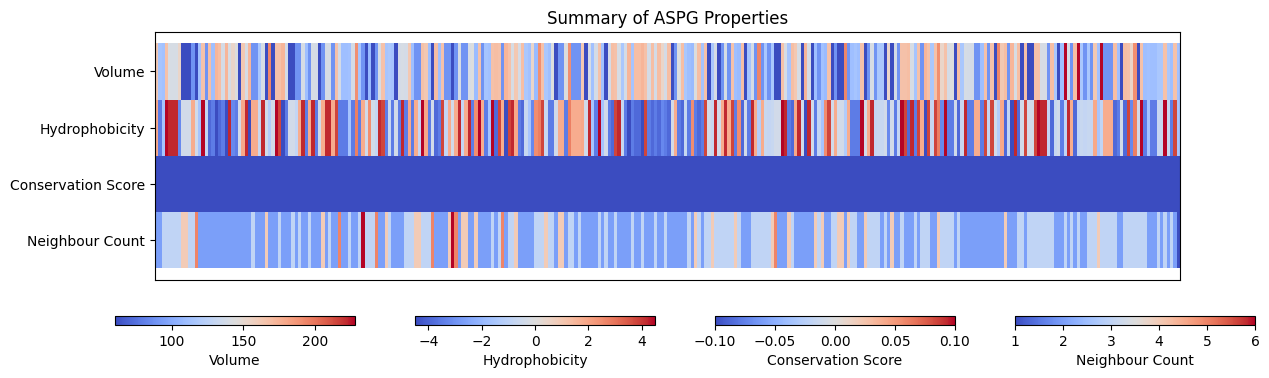

/home/codespace/.python/current/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5023.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5037.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 5051.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5065.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5145.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/Bio/PDB/StructureBuilder

Number of Amino Acids (1APY): 161
Merged Residue (1APY):[{'residue_id': 2, 'residue_name': 'SER', 'conservation_score': -0.159, 'neighbour_count': 1, 'hydrophobicity': -0.8, 'volume': 89.0}, {'residue_id': 3, 'residue_name': 'PRO', 'conservation_score': 1.367, 'neighbour_count': 2, 'hydrophobicity': -1.6, 'volume': 112.7}, {'residue_id': 4, 'residue_name': 'LEU', 'conservation_score': 2.29, 'neighbour_count': 2, 'hydrophobicity': 3.8, 'volume': 166.7}, {'residue_id': 5, 'residue_name': 'PRO', 'conservation_score': -1.272, 'neighbour_count': 2, 'hydrophobicity': -1.6, 'volume': 112.7}, {'residue_id': 6, 'residue_name': 'LEU', 'conservation_score': 0.941, 'neighbour_count': 2, 'hydrophobicity': 3.8, 'volume': 166.7}, {'residue_id': 7, 'residue_name': 'VAL', 'conservation_score': -0.355, 'neighbour_count': 2, 'hydrophobicity': 4.2, 'volume': 140.0}, {'residue_id': 8, 'residue_name': 'VAL', 'conservation_score': -0.425, 'neighbour_count': 2, 'hydrophobicity': 4.2, 'volume': 140.0}, {'resid

/home/codespace/.python/current/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4931.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 4936.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4941.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 5035.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4714.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/Bio/PDB/StructureBuilder

Number of Amino Acids (1P4V): 296
Error processing file ASPG_conservation_scores/1P4V_consurf_summary.txt: list index out of range
Conservation scores not found for 1P4V, skipping merge_residue_data. Going straight to plotting.
Test [{'residue_id': 1, 'residue_name': 'THR', 'conservation_score': None, 'neighbour_count': 1, 'hydrophobicity': -0.7, 'volume': 116.1}, {'residue_id': 2, 'residue_name': 'THR', 'conservation_score': None, 'neighbour_count': 3, 'hydrophobicity': -0.7, 'volume': 116.1}, {'residue_id': 3, 'residue_name': 'ASN', 'conservation_score': None, 'neighbour_count': 3, 'hydrophobicity': -3.5, 'volume': 114.1}, {'residue_id': 4, 'residue_name': 'LYS', 'conservation_score': None, 'neighbour_count': 2, 'hydrophobicity': -3.9, 'volume': 168.6}, {'residue_id': 5, 'residue_name': 'PRO', 'conservation_score': None, 'neighbour_count': 3, 'hydrophobicity': -1.6, 'volume': 112.7}, {'residue_id': 6, 'residue_name': 'ILE', 'conservation_score': None, 'neighbour_count': 3, 'hydrophob

/home/codespace/.python/current/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4840.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4854.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 4863.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 4892.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4909.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/Bio/PDB/StructureBuilder

Number of Amino Acids (4R4Y): 294
Error processing file ASPG_conservation_scores/4R4Y_consurf_summary.txt: list index out of range
Conservation scores not found for 4R4Y, skipping merge_residue_data. Going straight to plotting.
Test [{'residue_id': 3, 'residue_name': 'ASN', 'conservation_score': None, 'neighbour_count': 2, 'hydrophobicity': -3.5, 'volume': 114.1}, {'residue_id': 4, 'residue_name': 'LYS', 'conservation_score': None, 'neighbour_count': 2, 'hydrophobicity': -3.9, 'volume': 168.6}, {'residue_id': 5, 'residue_name': 'PRO', 'conservation_score': None, 'neighbour_count': 3, 'hydrophobicity': -1.6, 'volume': 112.7}, {'residue_id': 6, 'residue_name': 'ILE', 'conservation_score': None, 'neighbour_count': 3, 'hydrophobicity': 4.5, 'volume': 166.7}, {'residue_id': 7, 'residue_name': 'VAL', 'conservation_score': None, 'neighbour_count': 3, 'hydrophobicity': 4.2, 'volume': 140.0}, {'residue_id': 8, 'residue_name': 'LEU', 'conservation_score': None, 'neighbour_count': 3, 'hydrophobic

/home/codespace/.python/current/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4719.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4893.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4780.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 4841.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4802.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/Bio/PDB/StructureBuilder

Merged Residue (9GAC):[{'residue_id': 2, 'residue_name': 'THR', 'conservation_score': 1.983, 'neighbour_count': 2, 'hydrophobicity': -0.7, 'volume': 116.1}, {'residue_id': 3, 'residue_name': 'ASN', 'conservation_score': 1.403, 'neighbour_count': 3, 'hydrophobicity': -3.5, 'volume': 114.1}, {'residue_id': 4, 'residue_name': 'LYS', 'conservation_score': 1.716, 'neighbour_count': 2, 'hydrophobicity': -3.9, 'volume': 168.6}, {'residue_id': 5, 'residue_name': 'PRO', 'conservation_score': -0.954, 'neighbour_count': 3, 'hydrophobicity': -1.6, 'volume': 112.7}, {'residue_id': 6, 'residue_name': 'ILE', 'conservation_score': 0.802, 'neighbour_count': 3, 'hydrophobicity': 4.5, 'volume': 166.7}, {'residue_id': 7, 'residue_name': 'VAL', 'conservation_score': -0.205, 'neighbour_count': 3, 'hydrophobicity': 4.2, 'volume': 140.0}, {'residue_id': 8, 'residue_name': 'LEU', 'conservation_score': -0.171, 'neighbour_count': 3, 'hydrophobicity': 3.8, 'volume': 166.7}, {'residue_id': 9, 'residue_name': 'SER'

/home/codespace/.python/current/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4954.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 4959.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4964.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 5071.
  warnings.warn(


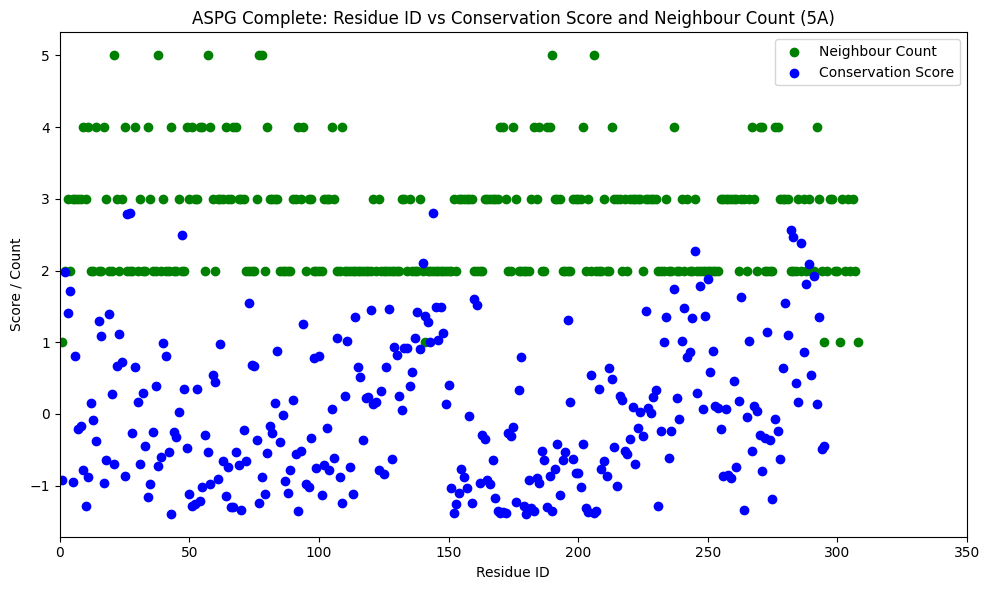

/tmp/ipykernel_1509/787728582.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


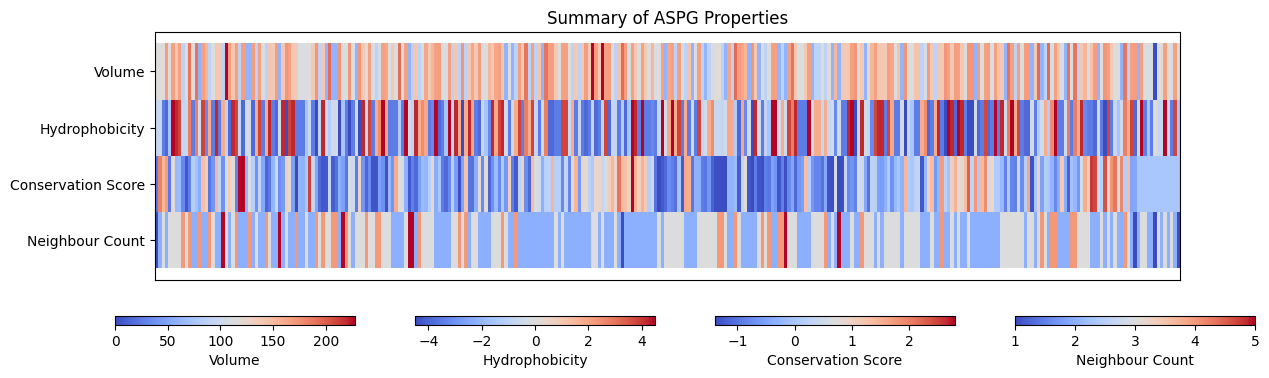

Summary for 1AYY chain A saved successfully at ASPG_conservation_scores/1AYY_consurf_summary.txt.
Summary for 1APZ chain A saved successfully at ASPG_conservation_scores/1APZ_consurf_summary.txt.
Summary for 1APY chain A saved successfully at ASPG_conservation_scores/1APY_consurf_summary.txt.
Summary for 2GAW chain A saved successfully at ASPG_conservation_scores/2GAW_consurf_summary.txt.
Summary for 2GL9 chain A saved successfully at ASPG_conservation_scores/2GL9_consurf_summary.txt.
Summary for 3LJQ chain A saved successfully at ASPG_conservation_scores/3LJQ_consurf_summary.txt.
Summary for 2GAC chain A saved successfully at ASPG_conservation_scores/2GAC_consurf_summary.txt.
Summary for 1P4V chain A saved successfully at ASPG_conservation_scores/1P4V_consurf_summary.txt.
Summary for 4R4Y chain A saved successfully at ASPG_conservation_scores/4R4Y_consurf_summary.txt.
Summary for 9GAF chain A saved successfully at ASPG_conservation_scores/9GAF_consurf_summary.txt.
Summary for 5V2I cha

In [108]:
pdb_file_path = ['./ASPG_pdb/pdb1apy.pdb', './ASPG_pdb/pdb1apz.pdb', './ASPG_pdb/pdb1ayy.pdb', './ASPG_pdb/pdb1p4k.pdb', './ASPG_pdb/pdb1p4v.pdb', './ASPG_pdb/pdb2gac.pdb', './ASPG_pdb/pdb2gaw.pdb', './ASPG_pdb/pdb2gl9.pdb', './ASPG_pdb/pdb3ljq.pdb', './ASPG_pdb/pdb4r4y.pdb', './ASPG_pdb/pdb5v2i.pdb', './ASPG_pdb/pdb9gaa.pdb', './ASPG_pdb/pdb9gac.pdb', './ASPG_pdb/pdb9gaf.pdb']

download_conservation_scores(pdb_file_path, chains = ['A'], protein_id='ASPG')

ref_seq = './ASPG_pdb/AF-Q7L266-F1-model_v4.pdb'
ref_seq = pdb_to_compiled_vector(ref_seq, angstrom = 5, protein_id = 'ASPG', num_residues = 350)
print(f"Ref Seq:{ref_seq}")
plot_residue_properties(ref_seq, protein_id="ASPG", num_residues = 350)

for pdb_file in pdb_file_path:
        completed = pdb_to_compiled_vector(pdb_file, angstrom = 5, protein_id = 'ASPG', num_residues = 350)
        updated_ref_seq = merge_to_ref_seq(ref_seq, completed)

print(f"Updated Seq: {updated_ref_seq}")
save_to_csv(updated_ref_seq, filename='ASPG1.csv')
plot_and_calculate_correlation(updated_ref_seq, angstrom = 5, protein_id = "ASPG", num_residues = 350)
plot_residue_properties(updated_ref_seq, protein_id="ASPG", num_residues = 350)
#correlation_plot(updated_ref_seq, angstrom = 5, protein_id='ASPG')
